In [59]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [60]:
rootfolder = '..'

In [61]:
def psnrFun(m1, m2):
    diff = (m1 - m2).reshape(-1)
    mse = np.dot(np.transpose(diff), diff) / diff.shape[0]
    psnr = 10*np.log10(1/mse)
    return psnr

Load the image and rescale it in $[0,1]$

In [62]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255
#img = img[50:200, 50:200]
imsz = img.shape

# patch size
p = 7

# number of elements in the patch
M = p ** 2

# radius of the search neighborhood
H = 15

# padding width
h = p // 2


Corrupt the image with white gaussian noise

In [63]:
sigma_noise = 20 / 255
noisy_img = img + sigma_noise * np.random.randn(*img.shape)

Compute the psnr of the noisy input

In [64]:
psnr_noisy = psnrFun(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 22.08')

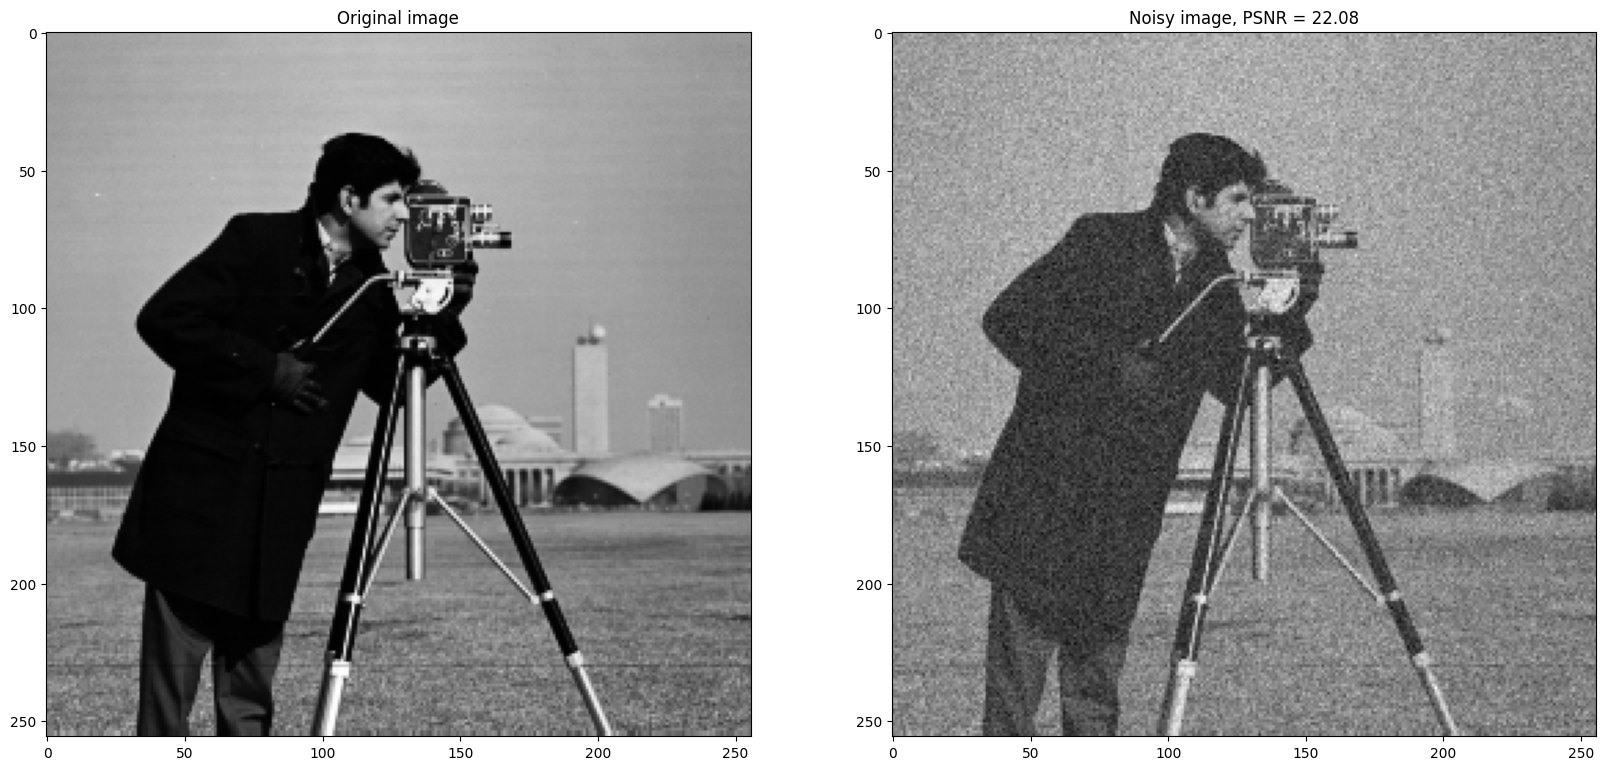

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')


Pixel-based NL-Means
--------------------
Set parameters and initialize the variables

In [66]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# pad the noisy image
img_pad = np.pad(noisy_img, h, mode='symmetric')


Text(0.5, 1.0, 'Padded image')

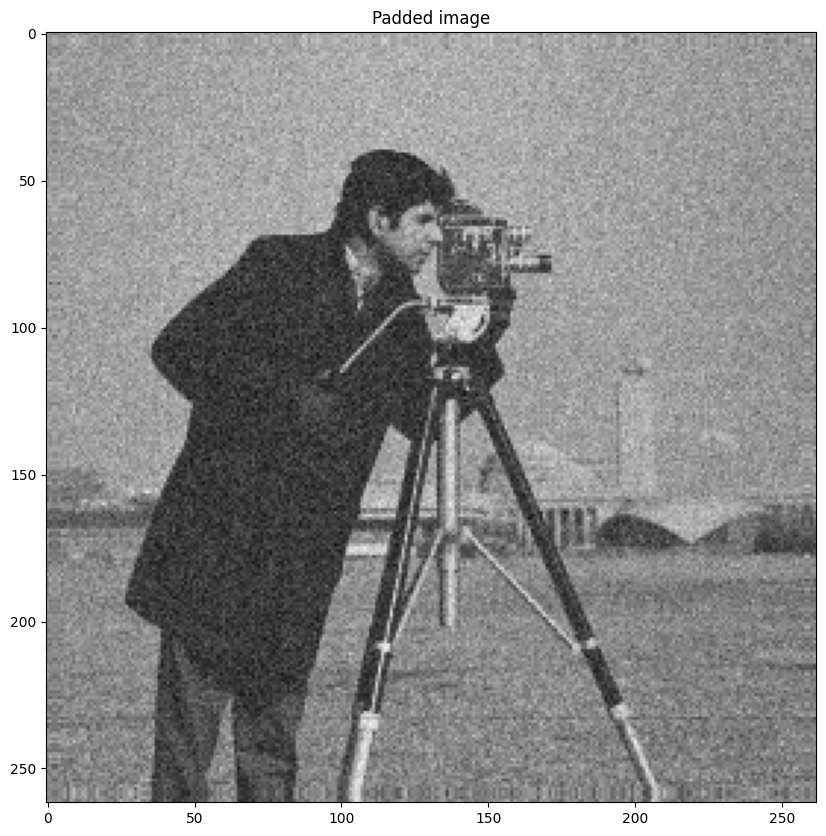

In [67]:
plt.figure(figsize=(10,10))
plt.imshow(img_pad, cmap='gray')
plt.title('Padded image')

Main loop

In [68]:
for i in range(0, imsz[0]):
    for j in range(0, imsz[1]):
        # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
        s = img_pad[i:i+p, j:j+p]

        # initialize the pixel estimate and the total weights
        pixel_hat = 0
        weight = 0
        for r in range(-H, H):
            for c in range(-H, H):
                if r + i >= 0 and r + i < imsz[0] and c + j >= 0 and c + j < imsz[1]:
                    # extract the patch
                    z = img_pad[r+i:r+p+i, c+j:c+p+j] 

                    # compute the distance with the reference patch
                    d = np.linalg.norm(s.reshape(-1) - z.reshape(-1))
                    w = np.exp(-d**2 / (M * sigma_noise**2))
                    # update the weight and the pixel estimate
                    pixel_hat += w * img_pad[r+i+h, c+j+h]
                    weight += w
                

        # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
        img_hat[i, j] = pixel_hat / weight


In [69]:
# for i in range(0, imsz[0]):
#     for j in range(0, imsz[1]):
#         # extrach the patch from img_pad whose center has the location (i, j) in the noisy image
#         s = img_pad[i:i+p, j:j+p]

#         # initialize the pixel estimate and the total weights
#         pixel_hat = 0
#         weight = 0
#         for r in range(-H, H):
#             for c in range(-H, H):
#                 if r + i >= 0 and r + i < imsz[0] and c + j >= 0 and c + j < imsz[1]:
#                     # extract the patch
#                     z = img_pad[r+i:r+p+i, c+j:c+p+j] 

#                     # compute the distance with the reference patch
#                     d = np.linalg.norm(s.ravel(order='F') - z.ravel(order='F'))
#                     w = np.exp(-d**2 / (M * 1**2))
#                     # update the weight and the pixel estimate
#                     pixel_hat = pixel_hat + w * img_pad[r+i+h, c+j+h]
#                     weight = weight + w
                

#         # estimate the pixel (i, j) as the weighted average of the central pixel of the extracted patches
#         img_hat[i, j] = pixel_hat / weight

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.47')

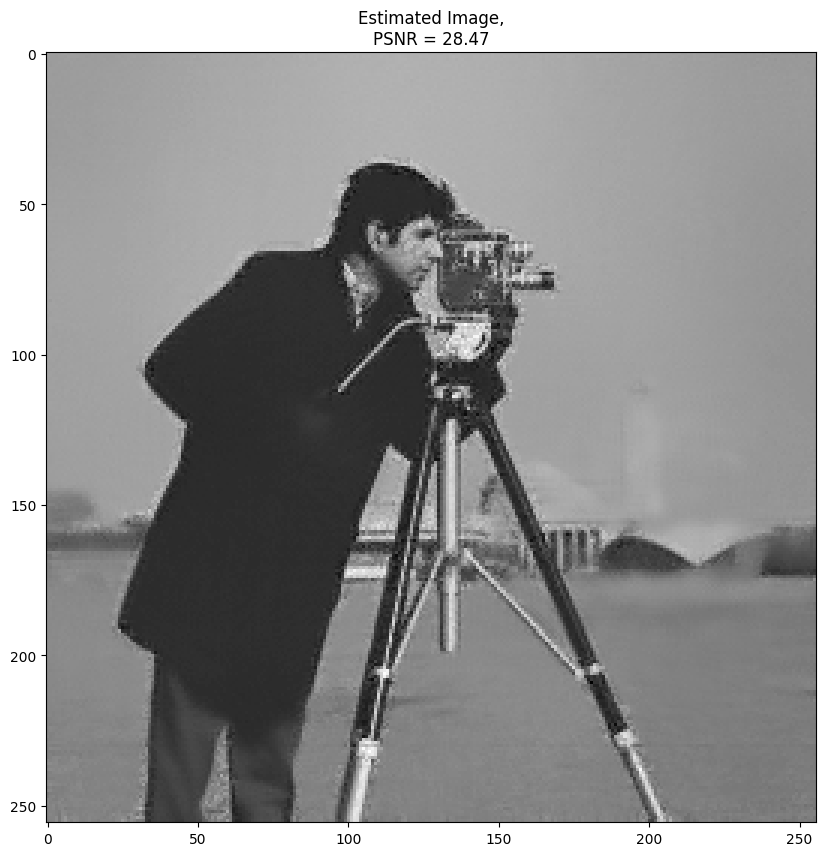

In [70]:
psnr_hat = psnrFun(img, img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
